In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
import qutip
from scipy.linalg import sqrtm

from povm_clf import *

---
# 1. State preparation

## Miaxed states

In [3]:
test = SingleQubitPOVM(bloch_vec=[0.7,0,0])
@qml.qnode(qml.device('default.qubit', wires=2))
def circ_test():
    test.state_prepared_on_circuit(wires=[0,1]) #요거 그림 그려보기!
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0, 0]
Output Bloch vector =  [7.00518230e-01 6.65558669e-04 2.89266589e-03]


### Circuit Diagram

In [4]:
diagram = qml.draw(circ_test)
print(diagram())

 0: ──Rot(1.45, 1.02, -0.85)───╭C──Rot(-1.96, 2.27, -6.07)──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──Rot(-2.52, -1.6, -4.13)──╰X──Rot(3.28, -2.6, -1.53)───╰┤ ⟨Z ⊗ Z⟩ 



---
# 2. Pure-state Classifier

##  Two-element POVM

In [9]:
n = 2
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1]
bloch_vecs = [[0,1,0], [0,-1,0]]
a_priori_probs = [1/n] * n

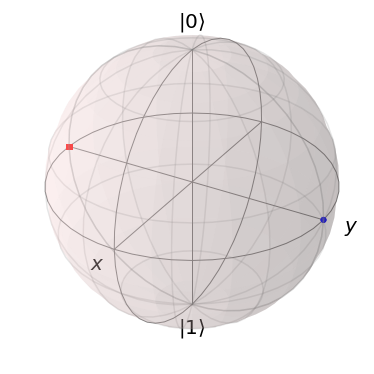

In [10]:
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [21]:
classifier = POVM_clf(2, wires, dev, a_priori_probs, bloch_vecs)
Helstrom_bound = classifier.spectral_decomp()
print(Helstrom_bound)

0.0


In [17]:
steps=200
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4987660
Cost after step    20:  0.4956657
Cost after step    40:  0.4679395
Cost after step    60:  0.1067236
Cost after step    80:  0.0015750
Cost after step   100:  0.0000233
Cost after step   120:  0.0000003
Cost after step   140:  0.0000000
Cost after step   160:  0.0000000
Cost after step   180:  0.0000000
Cost after step   200:  0.0000000


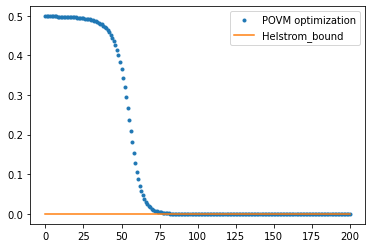

In [18]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound]*(steps+1), '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [19]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.9999999999999836
performed PGM: 2.220446049250313e-16


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.0000-0.5000j,0.5000+0.0000j,0.0000+0.5000j,,0.5000+0.0000j,0.0000-0.5000j,
,0.0000+0.5000j,0.5000+0.0000j,0.0000-0.5000j,0.5000+0.0000j,0.0000,0.0000+0.5000j,0.5000+0.0000j,1.0000
i=1,0.5000+0.0000j,0.0000+0.5000j,0.5000+0.0000j,-0.0000-0.5000j,,0.5000+0.0000j,0.0000+0.5000j,
,0.0000-0.5000j,0.5000+0.0000j,-0.0000+0.5000j,0.5000+0.0000j,0.0000,0.0000-0.5000j,0.5000+0.0000j,1.0000


## Three-element POVM

In [3]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]

"""
state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
"""

state_vecs = [[1, 0], [0, 1], [1/np.sqrt(2), 1/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
a_priori_probs = [1/n] * n

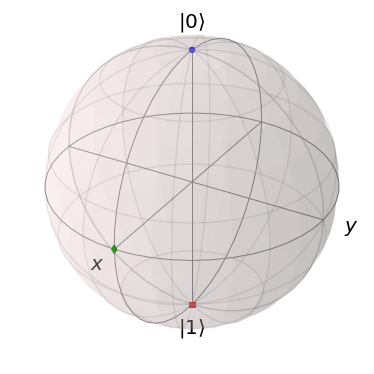

In [4]:
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [5]:
classifier = POVM_clf(n, wires, dev, a_priori_probs, bloch_vecs)

In [ ]:
steps = 600
cost_list = classifier.run_opt(steps)

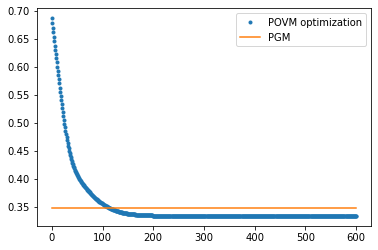

In [7]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
pgm, cost_pgm = classifier.pgm()
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="PGM")
plt.legend()
plt.show()

In [8]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.33333333410895793
performed PGM: 0.34763107293781825


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,1.0000+0.0000j,0.0000+0.0000j,1.0000+0.0000j,-0.0000-0.0000j,,0.7286+0.0000j,-0.1250+0.0000j,
,0.0000+0.0000j,0.0000+0.0000j,-0.0000+0.0000j,0.0000+0.0000j,1.0000,-0.1250+0.0000j,0.0214+0.0000j,0.7286
i=1,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,,0.0214+0.0000j,-0.1250+0.0000j,
,0.0000+0.0000j,1.0000+0.0000j,0.0000-0.0000j,1.0000+0.0000j,1.0000,-0.1250+0.0000j,0.7286+0.0000j,0.7286
i=2,0.5000+0.0000j,0.5000+0.0000j,0.0000+0.0000j,0.0000-0.0000j,,0.2500+0.0000j,0.2500+0.0000j,
,0.5000+0.0000j,0.5000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000,0.2500+0.0000j,0.2500+0.0000j,0.5000


---
# 3. Mixed-state Classifier

## Two-element POVM

In [22]:
n = 2
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2]
bloch_vecs = [[0.2,0,0], [-0.2,0,0]]
a_priori_probs = [1/n] * n

In [24]:
classifier = POVM_clf(2, wires, devs, a_priori_probs, bloch_vecs)
Helstrom_bound_exact = classifier.spectral_decomp()
Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.2, 0, 0]
Output Bloch vector =  [0.19820978 0.0006546  0.00154326]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.2, 0, 0]
Output Bloch vector =  [-0.20001478 -0.00167471 -0.00026973]


In [25]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4999858
Cost after step    20:  0.4999445
Cost after step    40:  0.4998611
Cost after step    60:  0.4996722
Cost after step    80:  0.4992358
Cost after step   100:  0.4982288
Cost after step   120:  0.4959360
Cost after step   140:  0.4908836
Cost after step   160:  0.4805763
Cost after step   180:  0.4628264
Cost after step   200:  0.4404106
Cost after step   220:  0.4215827
Cost after step   240:  0.4104329
Cost after step   260:  0.4049717
Cost after step   280:  0.4024733
Cost after step   300:  0.4013506
Cost after step   320:  0.4008480
Cost after step   340:  0.4006231
Cost after step   360:  0.4005225
Cost after step   380:  0.4004775
Cost after step   400:  0.4004574


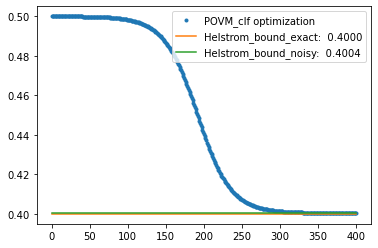

In [26]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [31]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("=== Minimum-Error Discrimination ===")
print("by performing optimal POVM:", med_povm)
print("by performing PGM:", med_pgm)

classifier.res_table()

=== Minimum-Error Discrimination ===
by performing optimal POVM: 0.400019001616845
by performing PGM: 0.4800000000000001


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.1000+0.0000j,0.5022+0.0000j,0.4999-0.0029j,,0.5000+0.0000j,0.1000+0.0000j,
,0.1000+0.0000j,0.5000+0.0000j,0.4999+0.0029j,0.4979+0.0000j,0.6001,0.1000+0.0000j,0.5000+0.0000j,0.5200
i=1,0.5000+0.0000j,-0.1000+0.0000j,0.4978+0.0000j,-0.4999+0.0029j,,0.5000+0.0000j,-0.1000+0.0000j,
,-0.1000+0.0000j,0.5000+0.0000j,-0.4999-0.0029j,0.5021+0.0000j,0.5999,-0.1000+0.0000j,0.5000+0.0000j,0.5200


## Three-element POVM

In [34]:
n = 3
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2, 3]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[0.8 * bloch_vecs[n][i] for i in range(3)] for n in range(n)]
a_priori_probs = [1/n] * n

In [35]:
classifier = POVM_clf(3, wires, devs, a_priori_probs, bloch_vecs)

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.39999999999999986, 0.6928203230275511, -1.2864981197413094e-16]
Output Bloch vector =  [-4.00409075e-01  6.92488730e-01  6.70355165e-05]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8, 0.0, -1.2864981197413094e-16]
Output Bloch vector =  [8.01676473e-01 1.91851447e-04 7.56585232e-04]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.39999999999999986, -0.6928203230275511, -1.2864981197413094e-16]
Output Bloch vector =  [-0.40031284 -0.69374326 -0.00358658]


In [36]:
steps=600
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.6772293
Cost after step    20:  0.6674295
Cost after step    40:  0.6555607
Cost after step    60:  0.6261053
Cost after step    80:  0.5411453
Cost after step   100:  0.4576413
Cost after step   120:  0.4371585
Cost after step   140:  0.4330013
Cost after step   160:  0.4309848
Cost after step   180:  0.4286998
Cost after step   200:  0.4255742
Cost after step   220:  0.4214423
Cost after step   240:  0.4165301
Cost after step   260:  0.4115238
Cost after step   280:  0.4072586
Cost after step   300:  0.4041939
Cost after step   320:  0.4022642
Cost after step   340:  0.4011450
Cost after step   360:  0.4005198
Cost after step   380:  0.4001731
Cost after step   400:  0.3999791
Cost after step   420:  0.3998690
Cost after step   440:  0.3998056
Cost after step   460:  0.3997687
Cost after step   480:  0.3997471
Cost after step   500:  0.3997344
Cost after step   520:  0.3997268
Cost after step   540:  0.3997224
Cost after step   560:  0.3997197
Cost after ste

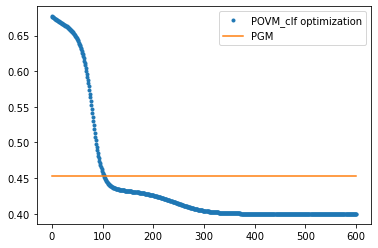

In [37]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
pgm, cost_pgm = classifier.pgm()
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="PGM")
plt.legend()
plt.show()

In [38]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("=== Minimum-Error Discrimination ===")
print("by performing optimal POVM:", med_povm)
print("by performing PGM:", med_pgm)

classifier.res_table()

=== Minimum-Error Discrimination ===
by performing optimal POVM: 0.40000279392619775
by performing PGM: 0.45333333333333337


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,-0.2000-0.3464j,0.3334+0.0000j,-0.1683-0.2873j,,0.3333-0.0000j,-0.1333-0.2309j,
,-0.2000+0.3464j,0.5000+0.0000j,-0.1683+0.2873j,0.3326+0.0000j,0.5994,-0.1333+0.2309j,0.3333-0.0000j,0.5467
i=1,0.5000+0.0000j,0.4000+0.0000j,0.3357+0.0000j,0.3350+0.0002j,,0.3333+0.0000j,0.2667+0.0000j,
,0.4000+0.0000j,0.5000+0.0000j,0.3350-0.0002j,0.3343+0.0000j,0.6030,0.2667+0.0000j,0.3333+0.0000j,0.5467
i=2,0.5000+0.0000j,-0.2000+0.3464j,0.3309+0.0000j,-0.1667+0.2871j,,0.3333+0.0000j,-0.1333+0.2309j,
,-0.2000-0.3464j,0.5000+0.0000j,-0.1667-0.2871j,0.3331+0.0000j,0.5976,-0.1333-0.2309j,0.3333+0.0000j,0.5467


---
Check Validity of Optimality Conditions

In [65]:
i, j = 0, 1
np.dot(np.dot(pgm[i], rho[i] - rho[j]), pgm[j])

tensor([[ 5.59737442e-18+5.80039465e-19j,
         -2.97500000e-02-1.71761705e-02j],
        [-2.97500000e-02+1.71761705e-02j,
          9.29811783e-18-2.16076401e-18j]], requires_grad=True)

In [72]:
i, j = 1, 2
np.dot(np.dot(E[i], rho[i] - rho[j]), E[j])

tensor([[-0.00043039-9.99921834e-06j,  0.00022485-3.68245770e-04j],
        [-0.00042896-9.23270331e-06j,  0.00022347-3.67389568e-04j]], requires_grad=True)

---
# 4. For various purities $\mathcal{P}$,

$\hat{\rho} = \frac{1}{2}(I+\vec{a}\cdot\hat{\sigma})$ <br>
$
\mathcal{P} = Tr[\hat{\rho}^2] = \frac{1}{2}(1+|\vec{a}|^2) \Longrightarrow
|\vec{a}| = \sqrt{2\mathcal{P}-1}
$ 

## 4-1. Two States

### Example 1
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (-\sqrt{2\mathcal{P}-1}, 0, 0)$

In [ ]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
ampltd_abs = [1, 0.7, 0.4, 0.1]
#Pure state


#Mixed state
steps = [100, 150, 200, 400]
for i, a in enumerate(ampltd_abs):
    
    bloch_vecs = [[a,0,0], [(-1)*a,0,0]]
    if a == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

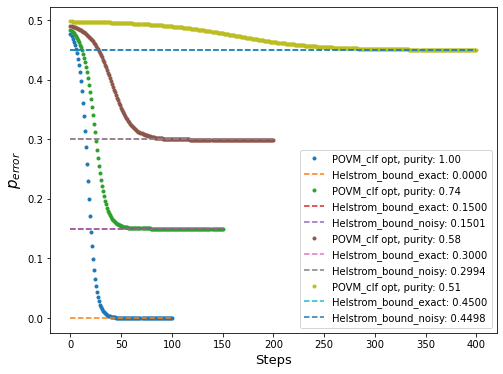

In [14]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((ampltd_abs[i]**2+1)/2))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_exact: {:.4f}".format(Hbe_list[i]))
    if i !=0:
        plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_noisy: {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result1.png', bbox_inches='tight', transparent=True)
plt.show()

### Example 2
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (0, 0, \sqrt{2\mathcal{P}-1})$

In [15]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
purities = [1, 0.85, 0.7, 0.55]


steps = [130, 170, 250, 500]
for i, p in enumerate(purities):
    
    bloch_vecs = [[np.sqrt(2*p-1),0,0], [0,0,np.sqrt(2*p-1)]]
    if p == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

Cost(init_params)    :  0.5131265
Cost after step    20:  0.2264332
Cost after step    40:  0.1508853
Cost after step    60:  0.1466824
Cost after step    80:  0.1464592
Cost after step   100:  0.1464473
Cost after step   120:  0.1464466
* Optimizing for preparing a mixed state ......

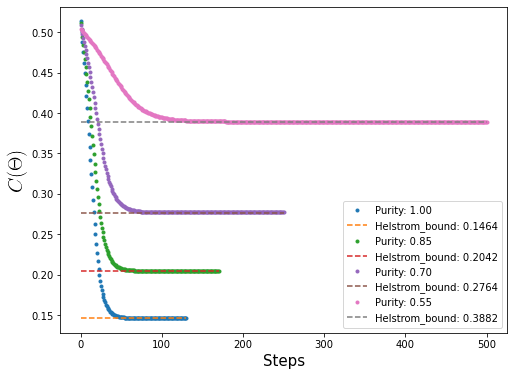

In [14]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound: {:.4f}".format(Hbe_list[i]))
    #if i !=0:
    #    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound, "+r"$\rho_{noisy}$"+": {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=15)
plt.ylabel(r'$C(\Theta)$', fontsize=20, usetex=True)
plt.legend()
plt.savefig('result2.png', bbox_inches='tight', transparent=True)
plt.show()

## 4-2. Three States

### Example 1
$|\psi_0\rangle = \left(|0\rangle + e^{2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_0=\sqrt{2\mathcal{P}-1}(-1/2, \sqrt{3}/2, 0)$<br>
$|\psi_1\rangle = \left(|0\rangle+|1\rangle\right)/\sqrt{2}$       ========> $\vec{a}_1 = \sqrt{2\mathcal{P}-1}(1,0,0) $ <br>
$|\psi_2\rangle = \left(|0\rangle + e^{-2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_2 = \sqrt{2\mathcal{P}-1}(-1/2, -\sqrt{3}/2, 0)$

In [34]:
n_qubit = 4
wires = [0, 1, 2, 3]
n_outcome = 3
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list = []
cost_pgm_list = []
purities = [1, 0.85, 0.7, 0.55]
steps = [300, 700, 700, 700]

for i, p in enumerate(purities):    
    state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
    bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(3)]
    bloch_vecs = [[np.sqrt(2*p-1) * bloch_vecs[n][i] for i in range(3)] for n in range(3)]

    if p == 1:
        classifier =POVM_clf(3, wires[:3], bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))

    else:
        classifier = POVM_clf(3, wires, bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))
    
    pgm, cost_pgm = classifier.pgm()
    cost_pgm_list.append(cost_pgm)

Cost(init_params)    :  0.7080831
Cost after step    20:  0.6506864
Cost after step    40:  0.5334323
Cost after step    60:  0.4012811
Cost after step    80:  0.3520046
Cost after step   100:  0.3387344
Cost after step   120:  0.3351352
Cost after step   140:  0.3340359
Cost after step   160:  0.3336414
Cost after step   180:  0.3334793
Cost after step   200:  0.3334058
Cost after step   220:  0.3333703
Cost after step   240:  0.3333524
Cost after step   260:  0.3333432
Cost after step   280:  0.3333385
Cost after step   300:  0.3333360
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.4183300132670376, 0.7245688373094721, -1.3454519387485027e-16]
Output Bloch vector =  [-0.41899513  0.72457413 -0.00076244]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8366600265340756, 0.0, -1.3454519387485027e-16]
Output Bloch vector =  [8.35795789e-01 4.77741450e-04 3.30869028e-03]
* Optimizing for 

In [37]:
cost_pgm_list

[0.3333333333333335,
 0.43333333333333335,
 0.5333333333333334,
 0.6333333333333332]

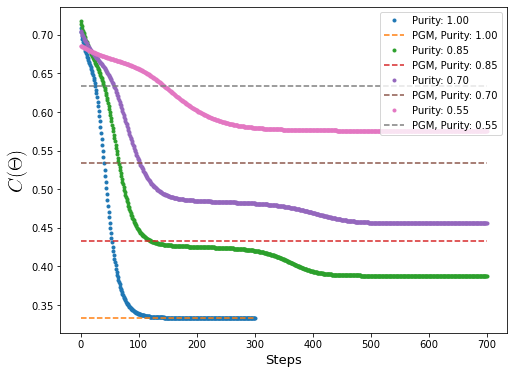

In [12]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    #cost_pgm
    plt.plot(list(range(steps[i]+1)), [cost_pgm_list[i]]*(steps[i]+1), '--', label="PGM, Purity:{: .2f}".format((purities[i])))


plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$C(\Theta)$', fontsize=20, usetex=True)
plt.legend()
plt.savefig('result3.png', bbox_inches='tight', transparent=True)
plt.show()

In [4]:
[cost_list[i][-1] for i in range(4)]

[0.333336019989774,
 0.38811440103983674,
 0.4557114445909325,
 0.5751731372929737]

`seed(9)` [0.333336019989774,
 0.38811440103983674,
 0.4557114445909325,
 0.5751731372929737]

`seed(10)`
[0.3334029406865143,
 0.40208094829335383,
 0.45379789753879407,
 0.5611921005937575]

그래프 조금 더 다듬기

### Example 2
$\vec{a}_0=\sqrt{2\mathcal{P}-1}(1, 0, 0)$<br>
$\vec{a}_1 = \sqrt{2\mathcal{P}-1}(0, 1, 0) $ <br>
$\vec{a}_2 = \sqrt{2\mathcal{P}-1}(0, 0, 1)$

In [3]:
n_qubit = 4
wires = [0, 1, 2, 3]
n_outcome = 3
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list = []
cost_pgm_list = []
purities = [1, 0.85, 0.7, 0.55]
steps = [300, 400, 400, 600]

for i, p in enumerate(purities):    
    bloch_vecs = [[1,0,0], [0,1,0], [0, 0, 1]]
    bloch_vecs = [[np.sqrt(2*p-1) * bloch_vecs[n][i] for i in range(3)] for n in range(3)]

    if p == 1:
        classifier =POVM_clf(3, wires[:3], bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))

    else:
        classifier = POVM_clf(3, wires, bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))
    
    pgm, cost_pgm = classifier.pgm()
    cost_pgm_list.append(cost_pgm)

Cost(init_params)    :  0.6806341
Cost after step    20:  0.5717313
Cost after step    40:  0.4399949
Cost after step    60:  0.4080400
Cost after step    80:  0.3996520
Cost after step   100:  0.3965569
Cost after step   120:  0.3953304
Cost after step   140:  0.3948449
Cost after step   160:  0.3946513
Cost after step   180:  0.3945715
Cost after step   200:  0.3945365
Cost after step   220:  0.3945201
Cost after step   240:  0.3945117
Cost after step   260:  0.3945072
Cost after step   280:  0.3945047
Cost after step   300:  0.3945033
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8366600265340756, 0.0, 0.0]
Output Bloch vector =  [ 0.83727665 -0.0027127  -0.00252595]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.0, 0.8366600265340756, 0.0]
Output Bloch vector =  [-7.07989662e-04  8.37538164e-01  1.56406598e-03]
* Optimizing for preparing a mixed state .............................

In [12]:
len(cost_list[0])

301

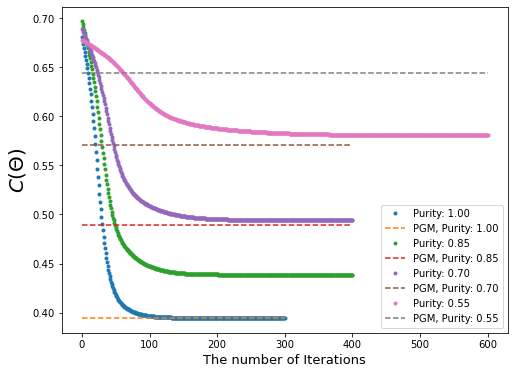

In [30]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    #cost_pgm
    plt.plot(list(range(steps[i]+1)), [cost_pgm_list[i]]*(steps[i]+1), '--', label="PGM, Purity:{: .2f}".format((purities[i])))


plt.xlabel('The number of Iterations', fontsize=13)
plt.ylabel("$C(\Theta)$", fontsize=20)
plt.legend()
plt.savefig('result4.png', bbox_inches='tight', transparent=True)
plt.show()

In [79]:
E = classifier.povm()
rho = classifier.density_matrices

In [80]:
np.trace(np.dot(E[0],rho[0]))

(0.4218252531205732+0j)

---
# Test
---

In [36]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 

from povm_clf_test import *

In [37]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n#, qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)] 
wires = [0, 1, 2]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)] 

In [38]:
np.random.seed(2)
params = 4 * np.pi * np.random.random([19])
params

tensor([ 5.47887353,  0.32579864,  6.90726241,  5.47042252,  5.2824976 ,
         4.15110979,  2.57169058,  7.78198847,  3.76557169,  3.35305043,
         7.80539794,  6.64939566,  1.69118147,  6.45381301,  2.31773971,
         9.86881252, 10.73137002,  6.21076327, 10.63820537], requires_grad=True)

In [39]:
params_opt = np.array([2.07716568, 7.85397763, 0.5236459 , 3.14159269, 1.23291917,
        1.59793933, 7.49892272, 2.84015056, 1.0471506 , 1.59700472,
        4.39604675, 6.28317501, 3.14158859, 8.04758825, 6.07043459,
        6.34899187, 4.86183644, 9.97314239, 7.28854747])
classifier = POVM_clf(n, wires, bloch_vecs, dev)
classifier.cost_fn(params), classifier.cost_fn(params_opt)

(0.6590201492131856, 0.4658705746335089)

In [42]:
classifier.povm_params

tensor([0.13036546, 6.30674213, 6.23007094, 1.68175146, 1.78582057,
        2.74648932, 5.2591289 , 3.11773123, 1.05632473, 4.34166396], requires_grad=True)

In [43]:
qnodes = qml.QNodeCollection()
for i in range(3):
    povm_circ = SingleQubitPOVM(n=3, bloch_vec = bloch_vecs[i])
    qnode = povm_circ(wires=wires, dev=dev[i])
    qnodes.append(qnode)
probs_povm = qnodes(params)
probs_povm

array([[8.18281620e-01, 0.00000000e+00, 1.00309875e-02, 1.71687392e-01],
       [7.98603265e-01, 7.70371978e-34, 1.62819042e-02, 1.85114830e-01],
       [8.03528796e-01, 7.73381243e-34, 8.09517569e-03, 1.88376028e-01]])

In [44]:
print(probs_povm[0][0], probs_povm[1][2], probs_povm[2][3])

0.8182816203882222 0.016281904151902307 0.18837602782031881


In [ ]:
probs_povm[0][0] + q[1] * probs_povm[1][2] + q[2] * probs_povm[2][3]

---
# CVXPY
---

In [58]:
import cvxpy as cp
import numpy as np